# Explore data augmentations

This notebook will be used to test different data augmentation strategies. In your config file, you can modify the augmentations by adding `data_augmentation_options`. For example, I would like to add a random RGB to gray transform with a probability of 0.2:
```
data_augmentation_options {
    random_rgb_to_gray {
    probability: 0.2
    }
```

A complete list of augmentation is provided the [`preprocessor.proto` file of the Tf Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto).

### Helper functions

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

In [20]:
def recenter_image(image):
    # ssd preprocessing
    image += [123.68, 116.779, 103.939]
    return image

def display_instances(image, bboxes, classes):
    image = recenter_image(image)
    w, h, _ = image.shape
    # resize the bboxes
    bboxes[:, [0, 2]] *= w
    bboxes[:, [1, 3]] *= h
    
    f, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image.astype(np.uint8))
    for bb, cl in zip(bboxes, classes):
        y1, x1, y2, x2 = bb
        rec = Rectangle((x1, y1), x2-x1, y2-y1, facecolor='none', edgecolor='r', linewidth=2)
        ax.add_patch(rec)
    plt.show()

def display_batch(batch):
    # get images, bboxes and classes
    batched_images = batch[0]['image'].numpy()
    batched_bboxes = batch[1]['groundtruth_boxes'].numpy()
    batched_classes = batch[1]['groundtruth_classes'].numpy()
    num_bboxes = batch[1]['num_groundtruth_boxes'].numpy()
    batch_size = batched_images.shape[0]
    for idx in range(batch_size):
        display_instances(batched_images[idx, ...], 
                          batched_bboxes[idx, :num_bboxes[idx], :],
                          batched_classes[idx, ...])

### Display augmentations

In [21]:
from utils import get_train_input

In [22]:
train_dataset = get_train_input("/home/workspace/experiments/reference/pipeline_new.config")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10096619443888687526_2820_000_2840_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10500357041547037089_1474_800_1494_800_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11388947676680954806_5427_320_5447_320_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11199484219241918646_2810_030_2830_030_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10072140764565668044_4060_000_4080_000_with_camera_labels.tfrecord', '/home/works

INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10096619443888687526_2820_000_2840_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10500357041547037089_1474_800_1494_800_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11388947676680954806_5427_320_5447_320_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-11199484219241918646_2810_030_2830_030_with_camera_labels.tfrecord', '/home/workspace/data/train/segment-10072140764565668044_4060_000_4080_000_with_camera_labels.tfrecord', '

INFO:tensorflow:Number of filenames to read: 86


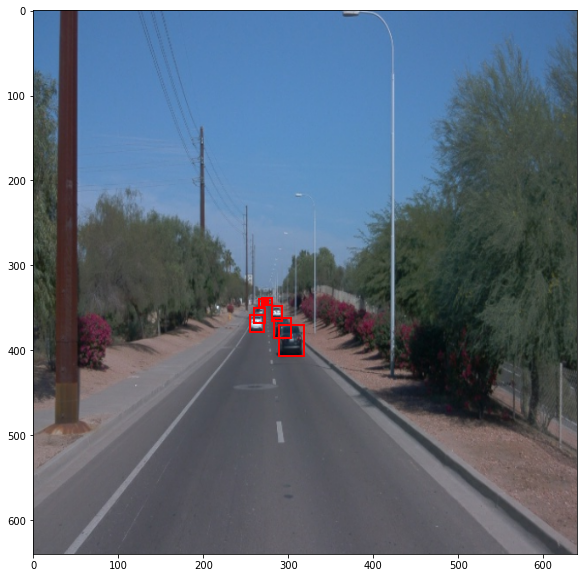

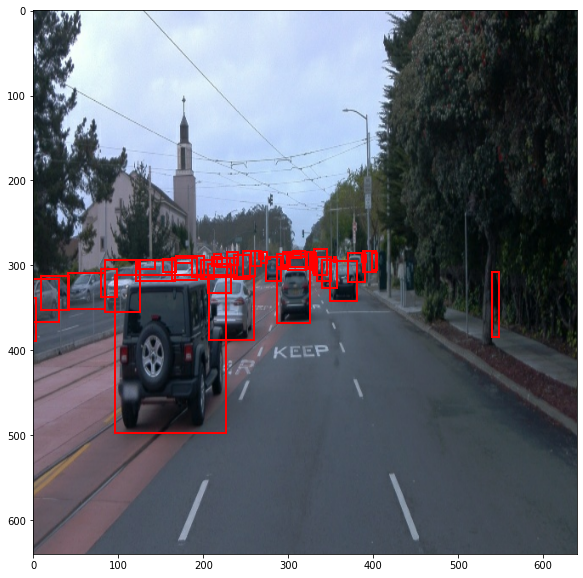

In [23]:
%matplotlib inline

for batch in train_dataset.take(1):
    display_batch(batch)

Image without augmentation: 


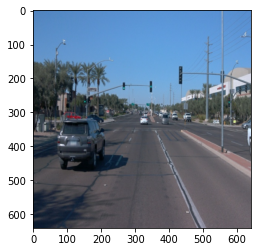

random_horizontal_flip


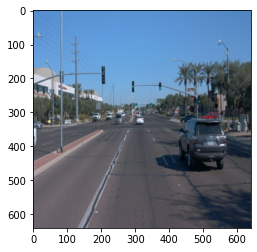

random_vertical_flip


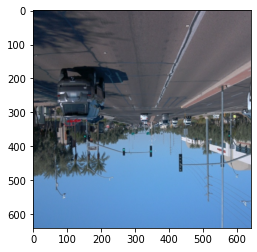

random_rotation90


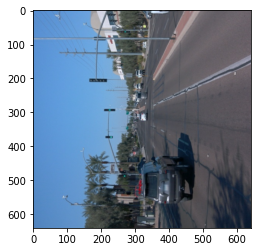

random_pixel_value_scale


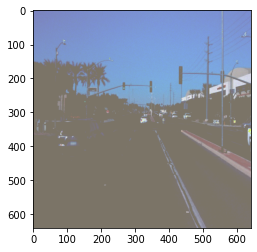

random_image_scale


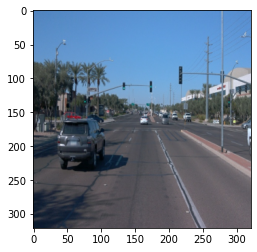

random_rgb_to_gray


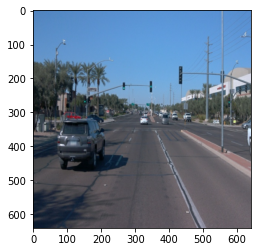

random_adjust_brightness


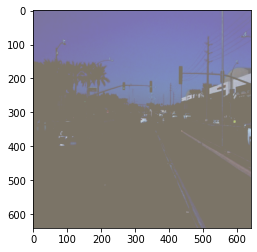

random_adjust_contrast


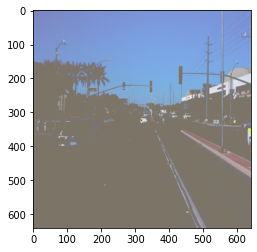

random_adjust_hue


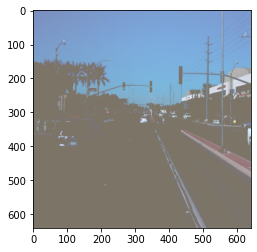

random_adjust_saturation


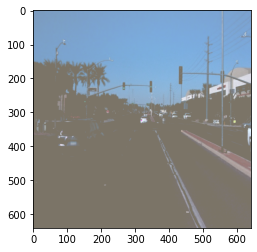

random_distort_color


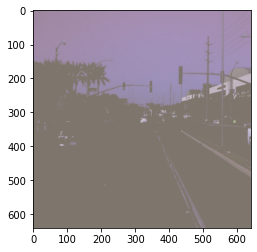

random_jitter_boxes
Cause: could not parse the source code:

        lambda x: random_jitter_box(x, ratio, seed), boxes, dtype=tf.float32)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

        lambda x: random_jitter_box(x, ratio, seed), boxes, dtype=tf.float32)

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


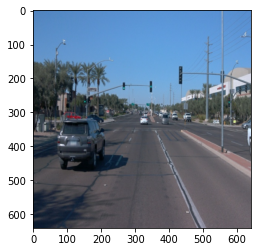

random_crop_image


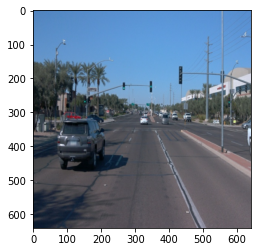

random_pad_image


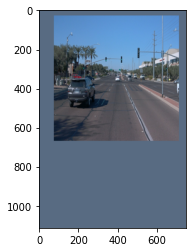

random_crop_pad_image


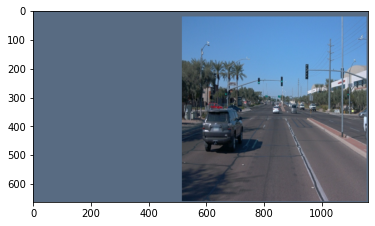

random_pad_to_aspect_ratio


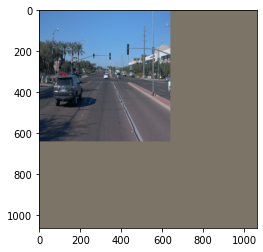

random_black_patches


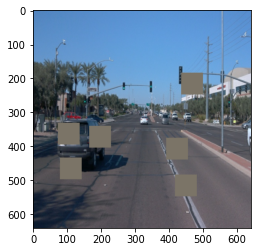

resize_to_min_dimension


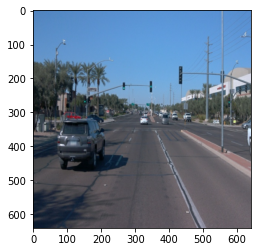

random_patch_gaussian


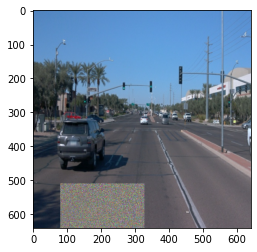

scale_boxes_to_pixel_coordinates


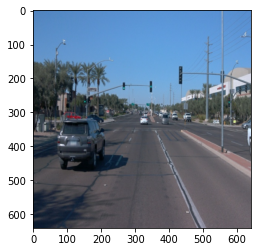

random_self_concat_image


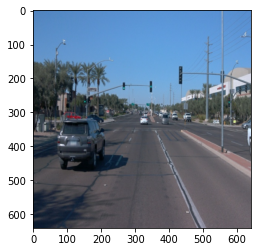

In [30]:
# https://stackoverflow.com/questions/53890669/save-tensorflow-object-detection-augmented-images
# https://github.com/majrie/visualize_augmentation/blob/master/visualize_augmentation.ipynb

# based on the function test_apply_image_and_box_augmentation from object detection api
# https://github.com/tensorflow/models/blob/master/research/object_detection/inputs_test.py

# This code is mainly from object detection API jupyter notebook and object detection API preprocessor.py
from object_detection.core import preprocessor
import functools, os
from object_detection import inputs
from object_detection.core import standard_fields as fields
from matplotlib import pyplot as mp
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import urllib.request
# This is needed to display the images.
%matplotlib inline

number_of_repeats = 1 # lot of augmentations have probabilities < 1 will not happen if repeated only once.
  
preprocessing_list = [None, 
                      (preprocessor.random_horizontal_flip, {}), 
                      (preprocessor.random_vertical_flip, {}), 
                      (preprocessor.random_rotation90, {}), 
                      (preprocessor.random_pixel_value_scale, {}), # slightly changes the values of pixels
                      (preprocessor.random_image_scale, {}),  
                      (preprocessor.random_rgb_to_gray, {}),
                      (preprocessor.random_adjust_brightness, {}),
                      (preprocessor.random_adjust_contrast, {}),
                      (preprocessor.random_adjust_hue, {}),
                      (preprocessor.random_adjust_saturation, {}),
                      (preprocessor.random_distort_color, {}), # very strong augmentation
                      (preprocessor.random_jitter_boxes, {}),
                      (preprocessor.random_crop_image, {}), 
                      (preprocessor.random_pad_image, {}), # changes the pixel values
                      (preprocessor.random_crop_pad_image, {}), 
                      (preprocessor.random_pad_to_aspect_ratio, {}),
                      (preprocessor.random_black_patches, {}),
                      (preprocessor.resize_to_min_dimension, {}),
                      (preprocessor.random_patch_gaussian, {}),
                      (preprocessor.scale_boxes_to_pixel_coordinates, {}), 
                      (preprocessor.random_self_concat_image, {}),
                    ]

for batch in train_dataset.take(1):
    #plt.imshow(recenter_image(batch[0]['image'][0].numpy()).astype(np.uint8))
    #plt.show()
    for preprocessing_technique in preprocessing_list:
        for i in range(number_of_repeats):

            if preprocessing_technique is  not None:
                print(str(preprocessing_technique[0].__name__))
            else:
                print('Image without augmentation: ')

            if preprocessing_technique is not None:
                data_augmentation_options = [preprocessing_technique]
            else:
                data_augmentation_options = []

            data_augmentation_fn = functools.partial(
                    inputs.augment_input_data,
                    data_augmentation_options=data_augmentation_options)

            tensor_dict = {
                    fields.InputDataFields.image:
                        tf.constant(batch[0]['image'][0].numpy().astype(np.float32)), # change the image variable here
                    fields.InputDataFields.groundtruth_boxes:
                        tf.constant(np.array([[.5, .5, 1., 1.]], np.float32)),
                    fields.InputDataFields.groundtruth_classes:
                        tf.constant(np.array([1.0], np.float32)),
                }

            augmented_tensor_dict = data_augmentation_fn(tensor_dict=tensor_dict)

            plt.figure()
            plt.imshow(recenter_image(augmented_tensor_dict[fields.InputDataFields.image].numpy()).astype(np.uint8))
            plt.show()
    break
